<a href="https://colab.research.google.com/github/alexeiveselov92/Yandex-Data-Analysis/blob/master/%D0%92%D1%8B%D1%8F%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%BF%D1%80%D0%BE%D1%84%D0%B8%D0%BB%D0%B5%D0%B9%20%D0%BF%D0%BE%D1%82%D1%80%D0%B5%D0%B1%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%BF%D0%BE%D0%BA%D1%83%D0%BF%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9%20%D0%BC%D0%B0%D0%B3%D0%B0%D0%B7%D0%B8%D0%BD%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-commerce — Выявление профилей потребления
### Задача
Сегментировать покупателей по профилю потребления
### Описание шагов
- Проведем исследовательский анализ данных
- Сегментируем покупателей на основе истории их покупок
- Сформируем сегменты на основе того, что покупают пользователи. Для этого проанализируем их покупки и сегментируем товары на основе принадлежности к той или иной товарной категории.

## Оглавление
* **Спецификация данных**
* **Загрузка библиотек**
* **Предобработка данных**
* **Исследовательский анализ данных**
  * Разобъем товары на категории
  * ТОП 5 продаваемых товаров в каждой категории
  * Графики выручки и количества покупателей по категориям
  * Сегментируем наших покупателей по истории покупок
  * Сегментируем покупателей по числовым признакам
  * Смотрим сезонность товаров по категориям
  * Сравниваем полученные сегменты по средним значениям метрик
  * График средней выручки с покупателя по сегментам покупателей
  * График количества заказов по сегментам покупателей
* **Вывод**
  * Ссылка на презентацию в выводе






## Спецификация

>**Файл ecommerce_dataset.csv содержит колонки:**
* **`date`** — *Дата заказа*
* **`customer_id`** — *Идентификатор покупателя*
* **`order_id`** — *Идентификатор заказа*
* **`product`** — *Наименование товара*
* **`quantity`** — *Количество товара в заказа*
* **`price`** — *Цена товара*

## Загрузка библиотек

In [0]:
import pandas as pd
import math as mth
from scipy import stats as st
import random
import numpy as np

#визуализация
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import seaborn as sns; sns.set()

#другое
pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')

#загрузка файлов с диска
from google.colab import drive
drive.mount('/content/drive')

#ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Предобработка данных

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final/ecommerce_dataset.csv')
df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
print('\nДубликатов в данных: {}'.format(df.duplicated().sum()))
print('Пропусков в данных не обнаружено')
df['date'] = df['datetime'].astype('datetime64[D]')
df['price_total'] = df['price'] * df['quantity']
df['month'] = df['datetime'].astype('datetime64[M]')
df.info()
df.head(5)


Дубликатов в данных: 0
Пропусков в данных не обнаружено
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6737 non-null   datetime64[ns]
 1   customer_id  6737 non-null   object        
 2   order_id     6737 non-null   int64         
 3   product      6737 non-null   object        
 4   quantity     6737 non-null   int64         
 5   price        6737 non-null   float64       
 6   datetime     6737 non-null   datetime64[ns]
 7   price_total  6737 non-null   float64       
 8   month        6737 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(2), object(2)
memory usage: 473.8+ KB


,date,customer_id,order_id,product,quantity,price,datetime,price_total,month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0,2018-10-01
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,194.0,2018-10-01
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,112.0,2018-10-01
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,179.0,2018-10-01
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,112.0,2018-10-01


## Исследовательский анализ данных
* построение распределений (гистограммы, боксплоты), поиск выбросов и аномалий
* поиск взаимосвязи в данных
* сегментирование покупателей с помощью ML


In [0]:
# сгруппируем датасет по заказам
grouped_by_orders = df.groupby(['customer_id', 'order_id']).agg({'price_total':'sum', 'price':'mean', 'product':'count', 'quantity':'sum', 'date':'first'}).reset_index()
grouped_by_orders = grouped_by_orders.rename(columns={'price_total':'order_price', 'price':'avg_price_of_product', 'product':'products_in_order', 'quantity':'goods_in_order'})

# сгруппируем датасет по пользователям
grouped_by_customers = grouped_by_orders.groupby('customer_id').agg({'order_id':'nunique', 
                                                                     'order_price':['sum', 'mean'], 
                                                                     'avg_price_of_product':'mean', 
                                                                     'products_in_order':'mean', 
                                                                     'goods_in_order':'mean'})
grouped_by_customers.columns = ['orders', 'total_revenue', 'avg_order_price', 'avg_price_of_product', 'avg_products_in_order', 'avg_goods_in_order']

print('Всего покупателей: {}'.format(len(df['customer_id'].unique())))
print('Всего заказов: {}'.format(len(df['order_id'].unique())))
print('В среднем заказов на одного покупателя (по моде): {}'.format(grouped_by_customers['orders'].mode()[0]))
print('Средняя выручка по покупателям составляет: {}$'.format(grouped_by_customers['total_revenue'].median()))
print('Средняя сумма заказа составляет: {}$'.format(grouped_by_customers['avg_order_price'].median()))
print('Средняя стоимость продукта по пользователям составляет: {}$'.format(grouped_by_customers['avg_price_of_product'].median()))
print('Среднее кол-во позиций в заказе по пользователям: {:.1f}'.format(grouped_by_customers['avg_products_in_order'].median())) 
print('Среднее кол-во единиц товара в заказе по пользователям: {:.1f}'.format(grouped_by_customers['avg_goods_in_order'].median()))   
grouped_by_customers.describe().loc['mean':]
# df.head()

Всего покупателей: 2451
Всего заказов: 2784
В среднем заказов на одного покупателя (по моде): 1
Средняя выручка по покупателям составляет: 741.0$
Средняя сумма заказа составляет: 727.0$
Средняя стоимость продукта по пользователям составляет: 340.5$
Среднее кол-во позиций в заказе по пользователям: 1.0
Среднее кол-во единиц товара в заказе по пользователям: 1.0


,orders,total_revenue,avg_order_price,avg_price_of_product,avg_products_in_order,avg_goods_in_order
mean,1.149327,1979.306406,1776.978439,774.151443,2.483619,6.180990
std,2.655249,14632.293841,14123.406563,1152.936168,18.791784,33.409783
min,1.000000,14.000000,14.000000,14.000000,1.000000,1.000000
25%,1.000000,328.500000,305.000000,134.000000,1.000000,1.000000
50%,1.000000,741.000000,727.000000,340.500000,1.000000,1.000000
75%,1.000000,1649.000000,1580.500000,974.000000,1.000000,3.000000
max,126.000000,675000.000000,675000.000000,14917.000000,888.000000,1000.000000


> * Как мы видим, покупатели редко возвращаются и более того, как правило, совершают разовые покупки и по одному товару в количестве 1-3 шт.
* Средняя выручка с 1 пользователя составляет 741\$
* Средняя сумма заказа составляет 727\$


In [0]:
# посмотрим динамику по продажам по месяцам
grouped_by_date = df.groupby('month').agg({'customer_id':'nunique', 'price_total':'sum'}).reset_index()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['price_total'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Динамика выручки по месяцам",
        'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Выручка, $",
    xaxis_title="Месяц")
fig.show()

fig = go.Figure(data=go.Scatter(x=grouped_by_date['month'], 
                                y=grouped_by_date['customer_id'], 
                                mode='lines',
                                stackgroup='one'))
fig.update_layout(
    title={
        'text': "Количество покупателей по месяцам",
        'xanchor': 'center',
        'x':0.5
    },
    yaxis_title="Количество покупателей",
    xaxis_title="Месяц")
fig.show()

> * Как мы видим выраженной сезонности по продажам нет
* В июне наблюдается пик продаж по выручке, но в нашем случае это обусловлено выбросами

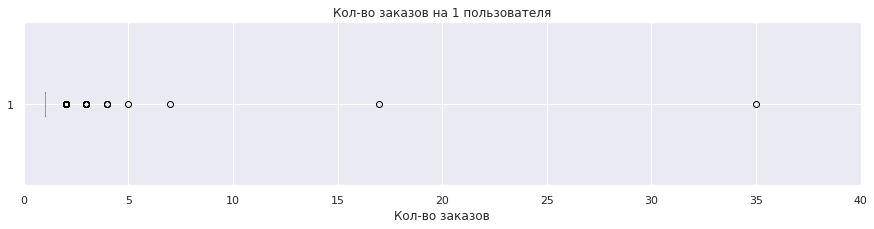

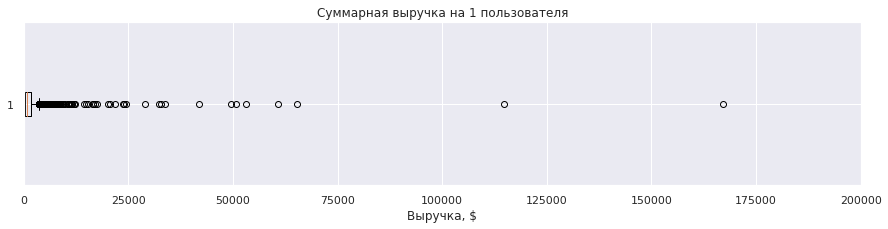

In [0]:
# теперь взглянем на выбросы - построим боксплоты
plt.figure(figsize=(15,3))
plt.title('Кол-во заказов на 1 пользователя')
plt.boxplot(grouped_by_customers['orders'], vert=False)
plt.xlabel('Кол-во заказов')
plt.xlim(0,40)
plt.show()
plt.figure(figsize=(15,3))
plt.title('Суммарная выручка на 1 пользователя')
plt.boxplot(grouped_by_customers['total_revenue'], vert=False)
plt.xlim(0,200000)
plt.xlabel('Выручка, $')
plt.show()

In [0]:
#составим списки с id клиентов, у которых аномально большая выручка и количество заказов
print('Аномально большое количество заказов у пользователей: >{:.0f}'.format(np.percentile(grouped_by_customers['orders'], 99)))
print('Аномально большая выручка по клиентам: >{:.0f}$'.format(np.percentile(grouped_by_customers['total_revenue'], 99)))
abnormal_orders_users = grouped_by_customers[grouped_by_customers['orders']>np.percentile(grouped_by_customers['orders'], 99)].index.to_list()
abnormal_revenue_users = grouped_by_customers[grouped_by_customers['total_revenue']>np.percentile(grouped_by_customers['total_revenue'], 99)].index.to_list()
abnormal_users = pd.concat([pd.Series(abnormal_orders_users), pd.Series(abnormal_revenue_users)]).to_list()
print('Покупателей с аномально большой выручкой: {}'.format(len(abnormal_revenue_users)))
print('Покупателей с аномально большим количеством заказов: {}'.format(len(abnormal_orders_users)))
#количество уникальных товаров и количество пользователей
print('Всего покупателей: {}'.format(df['product'].nunique()))
print('Всего товаров: {}'.format(len(grouped_by_customers)))

Аномально большое количество заказов у пользователей: >3
Аномально большая выручка по клиентам: >15108$
Покупателей с аномально большой выручкой: 25
Покупателей с аномально большим количеством заказов: 8
Всего покупателей: 2343
Всего товаров: 2451


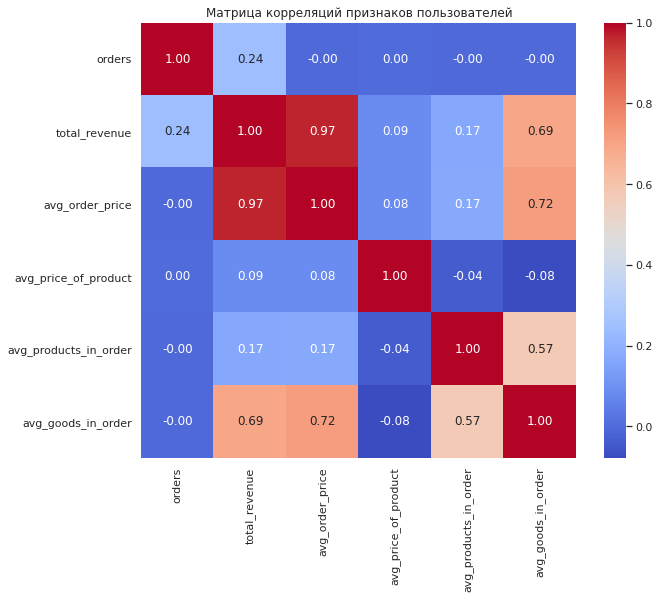

In [0]:
plt.figure(figsize=(10,8))
plt.title('Матрица корреляций признаков пользователей')
sns.heatmap(grouped_by_customers.corr(), annot=True, square=True, cmap='coolwarm', fmt='.2f')
plt.show()

> По матрице корреляций видно, что есть по логичным причинам коррелируемые признаки

Посмотрим на полученные признаки для пользователей - необходимо теперь добавить признаки, по которым сможем определить принадлежность пользователей к той или иной группе по категории купленных товаров. Для этого сначала разобъем товары на категории.

In [0]:
grouped_by_customers.head(5)

,orders,total_revenue,avg_order_price,avg_price_of_product,avg_products_in_order,avg_goods_in_order
customer_id,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,555.0,138.75,4.0,4.0
001cee7f-0b29-4716-b202-0042213ab038,1,442.0,442.0,442.00,1.0,1.0
00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,914.0,457.00,1.0,2.0
002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1649.0,1649.00,1.0,1.0
003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,2324.0,1162.00,1.0,2.0


### Разобъем товары на категории

In [0]:
#сформируем списки слов, по которым будем присваивать категории
plants = ['растение','пеларгония','помидор', 'герань','петуния','горшке','бакопа',
          'кассете','калибрахоа', 'базилик', 'петрушка', 'томат', 'кашпо',
          'лобелия', 'фуксия', 'вербена', 'цветк', 'смесь', "микс", 'земляника', 
          'клубника', 'ель', 'упаков', 'укроп', 'd-', 'камнеломка', 'примула',
          'вербейник', 'колокольчик', 'цикламен', 'барвинок', 'дыня', 'овсянница',
          'папоротник', 'кипарис', 'бегония', 'осина', 'арбуз']
seeds = [' г ']
for_house = ['покрытие', 'перчат', 'почтов',
             'чехол','ковр', 'ткан', 'штор', 'ковер',
             'термометр', 'ковёр', 'светил', 'весы']
for_bedroom = ['одеял', 'простын', 'подуш', 'плед', 'матрас', 'мыло', 'покрывало', 'спальн',
               'наволочка']
for_cleaning_and_washing = ['тряп', 'швабр', 'совок', 'гладил', 'глажен', 'прищеп', 'налет', 
                            'антижир', 'пылесос', 'крем', 'стир', 'щетка', 'сушилк', 'веник', 
                            'подрукавник', 'совком', 'для чистки', 'стирки', 'мыть', 'средство',
                            'мойк']
for_kitchen = ['блюдо','сковород','вилка','тарелк', 'ложка','фужер','посуд', 'кувшин', 'противень', 
               'соковыжим','лопатка', 'стакан','салатн','нож', 'бокал','чай','столов','банка','круж', 
               'толкушка','терка', 'варка','масл', 'чистка', 'салфет', 'кастрюл', 'webber','сахар', 
               'котел','wilmax', 'половник','скатерть', 'кипят','дозатор','зажиг','губка спираль', 
               'миска', 'термос', 'хлебница','кухон', 'кухн', 'бульон', 'выпеч', 'пресс', 'блюд']
storage = ['полки', 'вешал', 'плечики', 'стеллаж', 'хранен', 'крючок', "этажерка", 'комод', 
           'подставка', 'полка', 'кофр', 'лоток']
for_bathroom = ['ванн', 'полотен', 'ёрш', 'ерш', 'зуб', 'вантуз', 'халат']
containers = ['корыт', 'таз', 'контейнер', 'бак ', 'мусор', 'ведр', 'урна', 'корзин', 'бидон', 'ковш',
              'коробка', 'емкость']
instrument = ['инструмент', 'сверел', 'сверло', 'напильник', 'стремянк', 'стяжк', 'шпингалет', 
              'сварка', 'миксер', 'крепеж', 'пружин', 'петл', 'линейк', 'гои']
seedling = ['рассада']
bags_and_carts = ['сумка', 'тележ']
dummies = ['муляж', 'искусственн']
cuttings = ['черенок']

#напишем функцию присваивания категории в зависимости присутсвия слов из списка в названии продукта
df['category'] = 0
def categoryzer(list_of_words, category):
  join = '|'.join(list_of_words)
  index = df[df['product'].str.lower().str.contains(join)].index.to_list()
  for i in index:
    df.loc[i, 'category'] = category
  return df

# присвоим категории товарам в нашем датафрейме
categoryzer(plants, 'Растения')
categoryzer(seeds, 'Семена')
categoryzer(for_house, 'Разные товары для дома')
categoryzer(bags_and_carts, 'Сумки и тележки')
categoryzer(containers, 'Емкости')
categoryzer(storage, 'Для хранения')
categoryzer(dummies, 'Муляжи')
categoryzer(for_bedroom, 'Для спальни')
categoryzer(for_kitchen, 'Для кухни')
categoryzer(for_cleaning_and_washing, 'Для уборки и стирки')
categoryzer(for_bathroom, 'Для ванной')
categoryzer(instrument, 'Инструменты')
categoryzer(cuttings, 'Черенки')
categoryzer(seedling, 'Рассада')
df['category'] = df['category'].apply(lambda x: 'Другое' if (x==0) else x)

#выведем список полученных категорий и их соотношение
categoryzer_df = df.groupby('category').agg({'product':'count'}).reset_index()
categoryzer_df.columns = ['category', 'rows']
categoryzer_df['percent_of_rows'] = (categoryzer_df['rows'] / len(df)).round(3)
categoryzer_df['category'] = categoryzer_df['category'].replace(0, 'Без категории')
categoryzer_df = categoryzer_df.sort_values(by='percent_of_rows', ascending = False)
categoryzer_df['percent_of_rows'] = categoryzer_df['percent_of_rows'].map('{:.2%}'.format)
print(categoryzer_df)
print('\nСтрок без категории: {}'.format(len(df[df['category']==0])))

                  category  rows percent_of_rows
11                Растения  1841          27.30%
10                 Рассада  1599          23.70%
3      Для уборки и стирки   661           9.80%
13         Сумки и тележки   444           6.60%
1                Для кухни   426           6.30%
14                 Черенки   379           5.60%
8                   Муляжи   321           4.80%
0               Для ванной   268           4.00%
9   Разные товары для дома   202           3.00%
6                  Емкости   170           2.50%
4             Для хранения   150           2.20%
7              Инструменты   108           1.60%
5                   Другое    87           1.30%
2              Для спальни    39           0.60%
12                  Семена    42           0.60%

Строк без категории: 0


> Получили категории товаров - их вышло 15 штук. Больше всего товаров в категории "Растения", "Рассада", "Для уборки и стирки".

In [0]:
#сделаем функцию для поиска строк по комбинации букв и слов в названиях продуктов для проверки правильности разбивки на категории
def find_rows(text):
  result = df[df['product'].str.lower().str.contains(text)]
  print('Найдено строк: {}'.format(len(result)))
  return result

find_rows('растение').head(5)
# df.loc[2937, 'product']

Найдено строк: 109


,date,customer_id,order_id,product,quantity,price,datetime,price_total,month,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01 00:00:00,142.0,2018-10-01,Растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01 00:00:00,194.0,2018-10-01,Растения
22,2018-10-02,f08d9018-438e-4e96-b519-f74c0302a433,14480,Многолетнее растение Тимьян-чабрец розовый объ...,1,89.0,2018-10-02 11:00:00,89.0,2018-10-01,Растения
76,2018-10-04,e64aad3a-fffc-4193-8df5-e94a43eff295,68521,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-04 09:00:00,194.0,2018-10-01,Растения
195,2018-10-11,4d59d9e7-55be-43a0-88c4-8e7261c5c6d5,68610,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-11 13:00:00,142.0,2018-10-01,Растения


### ТОП 5 продаваемых товаров в каждой категории

In [0]:
grouped_by_category = df.query('customer_id not in @abnormal_users').groupby('category').agg({'customer_id':'nunique', 'price':'mean', 'price_total':'sum'})
grouped_by_category.columns = ['buyers', 'avg_product_price', 'revenue']
grouped_by_category['revenue_per_user'] = grouped_by_category['revenue'] / grouped_by_category['buyers']
grouped_by_category = grouped_by_category.sort_values(by='revenue_per_user', ascending = False)
grouped_by_category['percent_of_revenue'] = grouped_by_category['revenue'] / grouped_by_category['revenue'].sum()
grouped_by_category['percent_of_revenue'] = grouped_by_category['percent_of_revenue'].map('{:.2%}'.format)
grouped_by_category['percent_of_buyers'] = grouped_by_category['buyers'] / grouped_by_category['buyers'].sum()
grouped_by_category['percent_of_buyers'] = grouped_by_category['percent_of_buyers'].map('{:.2%}'.format)
print(grouped_by_category)

# сгруппируем товары
grouped_by_product = df.groupby('product').agg({'customer_id':'nunique', 'quantity':'mean', 'price':'mean', 
                                                'category':'first', 'price_total':'sum'}).reset_index().sort_values(by='customer_id', ascending=False)
grouped_by_product.columns = ['product', 'buyers', 'avg_quantity', 'price', 'category', 'total_revenue']

#выведем топ5 товаров в каждой категории по кол-ву покупателей
print('Кол-во товаров, которые приобрели 5 и более покупателей: {}\n'.format(len(grouped_by_product[grouped_by_product['buyers']>=5])))
for category in grouped_by_product['category'].unique():
  print('ТОП-5 {}:'.format(category))
  print(grouped_by_product[grouped_by_product['category']==category].head(5))
  print('')

                        buyers  avg_product_price   revenue  revenue_per_user percent_of_revenue percent_of_buyers
category                                                                                                          
Сумки и тележки            287        1926.678363  664358.0       2314.836237             20.80%            10.69%
Инструменты                 62        1489.392857  136290.0       2198.225806              4.27%             2.31%
Для хранения               105         867.104478  190098.0       1810.457143              5.95%             3.91%
Для спальни                 24        1168.296296   36053.0       1502.208333              1.13%             0.89%
Для уборки и стирки        468        1084.776978  689349.0       1472.967949             21.58%            17.44%
Для ванной                 191         776.453815  232808.0       1218.890052              7.29%             7.12%
Разные товары для дома     131         457.366120  150254.0       1146.977099   

### Графики выручки и количества покупателей по категориям
Графики будем строить по очищенным данным от аномальных покупателей

In [0]:
fig = px.bar(grouped_by_category.reset_index().sort_values(by='revenue', ascending = False), 
             x='category', y='revenue', width = 1300, height = 650, color='category', 
             text='revenue')
fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Доля выручки по категориям товаров',
    xaxis_title="Категория",
    yaxis_title="Выручка")
fig.update_traces(textposition='outside')
for trace, percent in zip(fig.data, grouped_by_category.reset_index().sort_values(by='revenue', ascending = False)['percent_of_revenue'].astype('str')):
    trace.name = trace.name.split('=')[1] + ' (' + percent + ' от выручки)'
fig.show()

fig = px.bar(grouped_by_category.reset_index().sort_values(by='buyers', ascending = False), 
             x='category', y='buyers', width = 1300, height = 650, color='category', 
             text='buyers')
fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Доля покупателей по категориям товаров',
    xaxis_title="Категория",
    yaxis_title="Кол-во покупателей")
fig.update_traces(textposition='outside')
for trace, percent in zip(fig.data, grouped_by_category.reset_index().sort_values(by='buyers', ascending = False)['percent_of_buyers'].astype('str')):
    trace.name = trace.name.split('=')[1] + ' (' + percent + ' от общего числа покупателей)'
fig.show()

> Видим, что по общей выручке лидируют категории "Для ванной", "Сумки и тележки" и "Для уборки и стирки". Всего товаров, которые купили 5 и более пользователей - 169.

### Сегментируем наших покупателей
Теперь сегментируем наших покупателей по всем имеющимся у нас признакам категорий с помощью машинного обучения, но сначала уберем из нашей сегментации аномальных покупателей.
При сегментации мы будем использовать только бинарные признаки наличия покупки у наших покупателей в той или иной категории - остальные метрики мы использовать не будем.

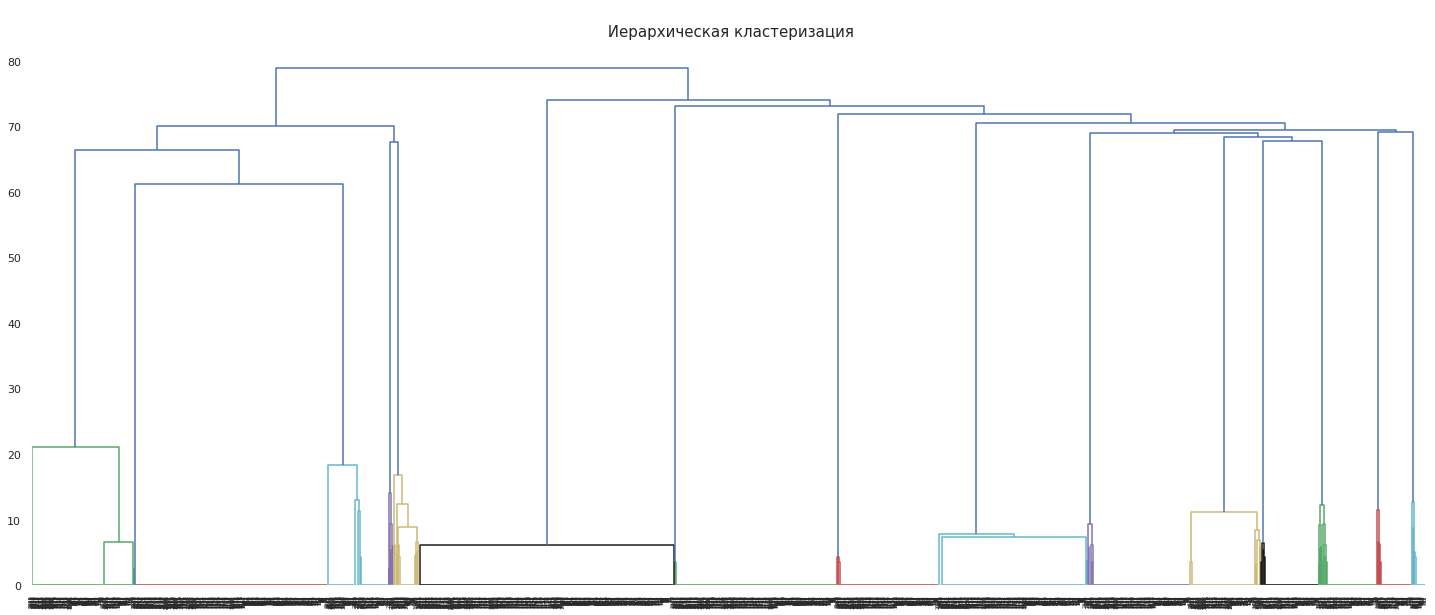

In [0]:
df['test_column'] = 1
classification = df.pivot_table(index = 'customer_id', columns = 'category', values='test_column', aggfunc='mean')
classification = classification.reset_index()
classification = classification.fillna(0)
classification = classification.query('customer_id not in @abnormal_users')
classification
X = classification.drop(['customer_id'], axis = 1)
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(25, 10))
dendrogram(linked, orientation='top')
plt.title('\n Иерархическая кластеризация', fontsize=15)
plt.show()
km = KMeans(n_clusters = 15, random_state = 0)
labels = km.fit_predict(X_st)
classification['cluster_km'] = labels

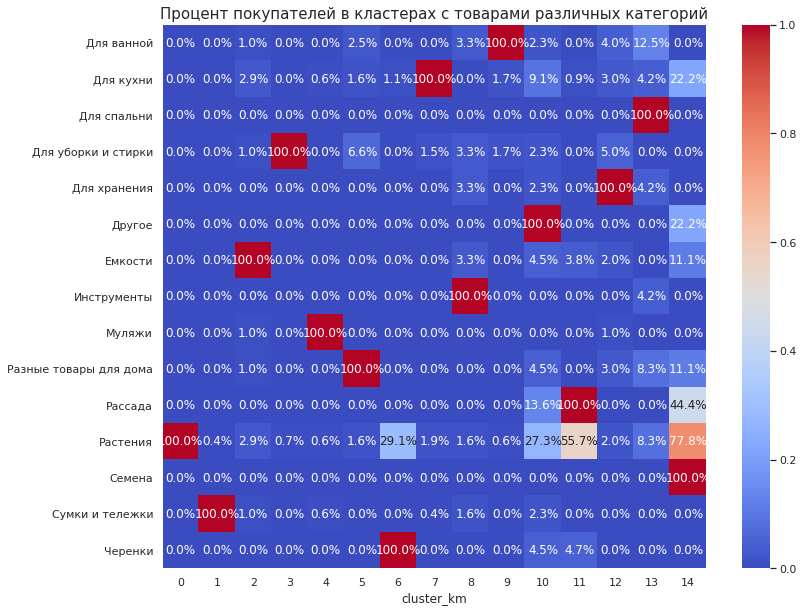

In [0]:
plt.figure(figsize=(13,10))
plt.title('Процент покупателей в кластерах с товарами различных категорий', fontsize = 15)
sns.heatmap(classification.groupby('cluster_km').mean().T.loc[:'Черенки'], annot=True, cmap='coolwarm', square=True, fmt='.1%')
plt.show()
#присвоим каждому кластеру основную категорию товаров
cluster_to_category = pd.DataFrame()
categories_list = ['Растения','Сумки и тележки','Емкости','Для уборки и стирки','Муляжи','Разные товары для дома',
                   'Черенки','Для кухни','Инструменты','Для ванной','Другое','Рассада','Для хранения','Для спальни',
                   'Семена']
for i, category in zip(range(0,15), categories_list):
  cluster_to_category.loc[i, 'category'] = category
cluster_to_category = cluster_to_category.reset_index()
cluster_to_category.columns = ['cluster_km', 'category']

> Мы получили 15 кластеров - сколько и категорий. Видим, что распределение произошло верно - каждому кластеру соответствует одна категория товаров, которые были куплены каждым покупателем из кластера. На категорию "Другое" при заключении выводов мы не смотрим, так как в неё преимущественно попали растения, черенки рассада и товары для дома, которые необходимо классифицировать по-хорошему, но так как категория мала и имеет незначительную выручку то мы просто про неё забываем.

> Мы так же по тепловой карте видим, зачастую одними и теми же покупателями приобретаются сразу несколько категорий товаров:
* Из тех, кто покупал черенки, 29% купили и растения
* Из тех, кто покупал рассаду, 55% купили и растения
* Из тех, кто покупал семена, 77% купили и растения, 44% рассаду, 11% емкости, 22% товары для кухни.

> Так же исходя из тепловой карты делаем вывод, что не считая 3 пунктов выше, в основном покупатели делают покупки товаров именно из какой-либо одной категории. 
Поэтому для создания спец предложений будем использовать топ наиболее покупаемых товаров внутри каждой из категорий. А в случае, когда покупателей интересуют категории "Семена", "Рассада" и "Черенки" мы можем помимо топ товаров одной выбранной покупателем категории предлагать топ товаров из двух других из этих трёх.

### Сегментируем покупателей только по числовым признакам и посмотрим что получается
Теперь сделаем сегментацию покупателей только по числовым признакам, которые мы получили в самом начале исследовательского анализа данных.



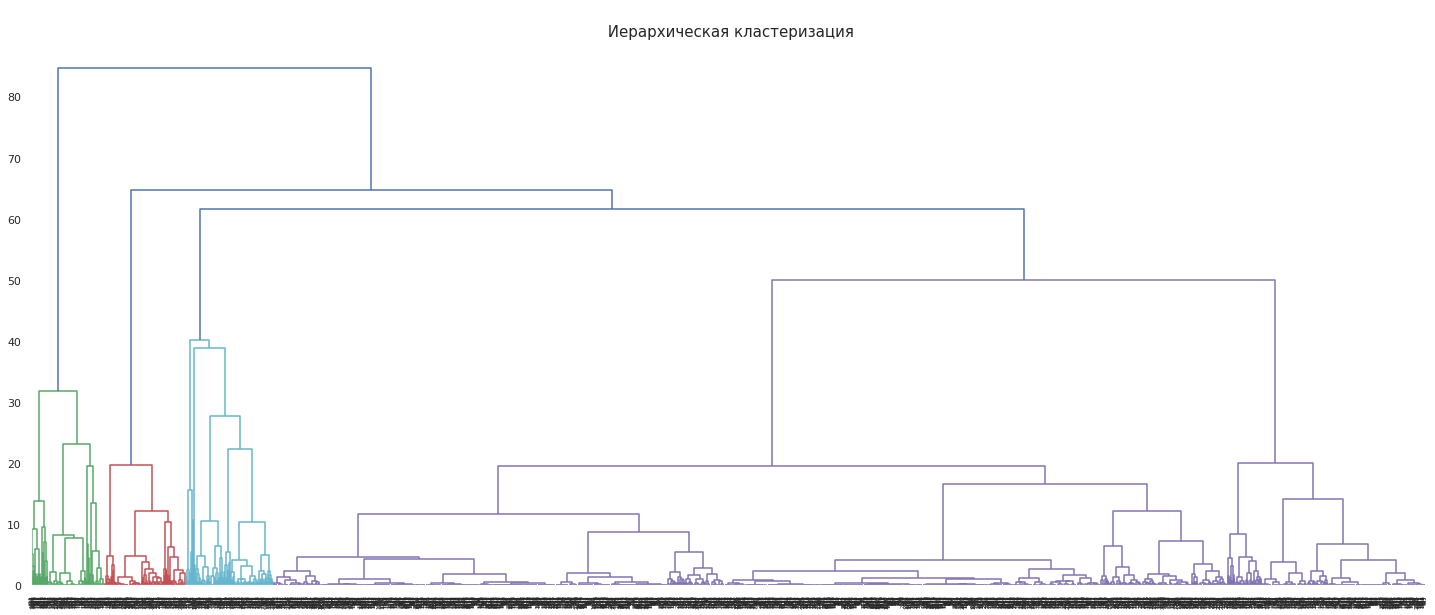

In [0]:
grouped_by_customers = grouped_by_customers.reset_index().query('customer_id not in @abnormal_users')
X = grouped_by_customers.drop(['customer_id'], axis = 1)
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(25, 10))
dendrogram(linked, orientation='top')
plt.title('\n Иерархическая кластеризация', fontsize=15)
plt.show()
km = KMeans(n_clusters = 4, random_state = 0)
labels = km.fit_predict(X_st)
grouped_by_customers['cluster_by_numeric_criteria'] = labels


> Только по числовым признакам мы получили 4 категории покупателей, сравним их и посмотрим как эти кластеры соотносятся с категориями товаров на тепловой карте.

In [0]:
classification = classification.merge(grouped_by_customers.reset_index(), on='customer_id')

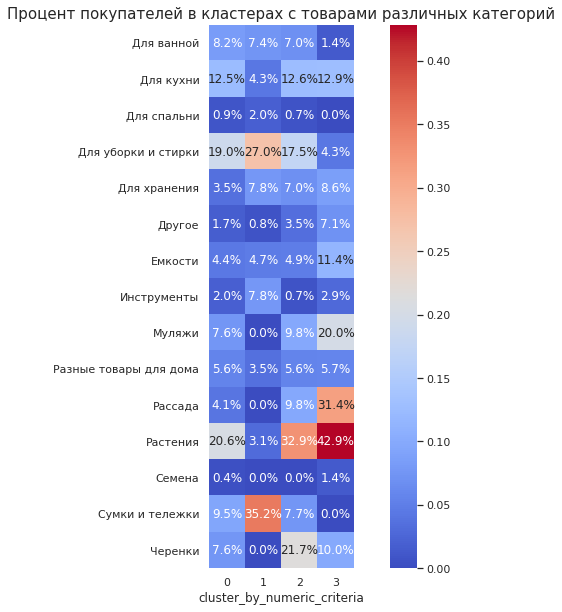

In [0]:
plt.figure(figsize=(13,10))
plt.title('Процент покупателей в кластерах с товарами различных категорий', fontsize = 15)
sns.heatmap(classification.groupby('cluster_by_numeric_criteria').mean().T.loc[:'Черенки'], annot=True, cmap='coolwarm', square=True, fmt='.1%')
plt.show()

> Мне такая классификация не очень нравится, мне кажется важным признаком все таки покупка в той или иной категории, а только при числовых признаках эта зависимость теряется, поэтому будем использовать предыдущую классификацию на 15 кластеров для составления спец. предложений

### Посмотрим сезонность товаров по категориям

In [0]:
df = df.merge(classification[['customer_id', 'cluster_km']], how='left', on='customer_id')
# classification = classification.merge(grouped_by_customers.reset_index(), on='customer_id')

In [0]:
seasonality = df.groupby('order_id').agg({'category':'first', 'month':'first', 'customer_id':'first'})\
.query('customer_id not in @abnormal_users')\
.groupby(['month', 'category']).agg({'customer_id':'count'}).reset_index()
seasonality.columns = ['month', 'category', 'orders']

data = []
for category in df['category'].unique():
  seasonality_by_category = seasonality[seasonality['category']==category]
  data += [go.Scatter(
          x = seasonality_by_category['month'],
          y = seasonality_by_category['orders'],
          mode = 'lines',
          # stackgroup = 'one',
          name = category
      )]
fig = go.Figure(data = data)
fig.update_layout(
    title={
        'text': "Сезонность товаров по категориям",
        'xanchor': 'center',
        'x':0.425
    },
    yaxis_title="Количетсво покупок",
    xaxis_title="Месяц")
fig.show()

> Есть товары с выраженной сезонностю, и это сочетается с логикой:
* Растения - пик покупок в апреле
* Товары для уборки и стирки, емкости, для хранения, для кухни и для ванной **реже** всего покупают в мае
* Рассада - пик покупок имеют в мае
* Черенки - пик в марте
* Сумки и тележки - пик в августе
* Инструмент в основном покупают осенью

### Сравним наши кластеры по средним значениям имеющихся метрик

In [0]:
comparison_clusters = classification.drop(['index'], axis = 1).groupby('cluster_km').describe().T.reset_index()
metrics = ['mean']
comparison_clusters = comparison_clusters.query('level_1 in @metrics').loc[121:].set_index('level_0').T
comparison_clusters = comparison_clusters.reset_index().merge(classification.groupby('cluster_km').agg({'customer_id':'count'}).reset_index(), on='cluster_km')
comparison_clusters = comparison_clusters.merge(cluster_to_category, on='cluster_km')
comparison_clusters = comparison_clusters[['category', 'cluster_km', 'customer_id', 'orders', 'total_revenue', 'avg_order_price',
                                           'avg_price_of_product', 'avg_products_in_order', 'avg_goods_in_order']]
comparison_clusters.columns = ['category', 'cluster_km', 'buyers', 'orders', 'revenue_per_buyer', 'avg_order_price',
                                           'avg_price_of_product', 'avg_products_in_order', 'avg_goods_in_order']
comparison_clusters['revenue_per_buyer'] = comparison_clusters['revenue_per_buyer'].astype('int')
comparison_clusters['orders'] = comparison_clusters['orders'].astype('float').round(2)
comparison_clusters

,category,cluster_km,buyers,orders,revenue_per_buyer,avg_order_price,avg_price_of_product,avg_products_in_order,avg_goods_in_order
0,Растения,0,336,1.04,766,744.333,292.735,1.90774,3.79018
1,Сумки и тележки,1,282,1.05,2339,2208.7,1944.35,1.15012,1.16785
2,Емкости,2,102,1.04,1310,1274.53,721.922,2.02451,5.43137
3,Для уборки и стирки,3,444,1.04,1494,1448.09,1128.44,1.15766,2.09009
4,Муляжи,4,175,1.09,615,586.523,63.9278,1.70286,12.4619
5,Разные товары для дома,5,122,1.05,1242,1221.16,554.705,1.47131,4.46721
6,Черенки,6,179,1.20,495,424.02,120.325,2.70484,3.25605
7,Для кухни,7,260,1.06,1069,1011.45,530.254,1.33654,4.22821
8,Инструменты,8,61,1.03,2199,2137.36,1518.92,1.45082,6.2623
9,Для ванной,9,177,1.07,1344,1253.04,840.389,1.28531,2.49435


> Опишем разницумежду кластерами по средним значеним:
* Видим, что по количеству покупок между кластерами нет существенных различий
* По средней выручке с пользователя разница есть, что вполне логично, так как в разных категориях товаров разные средние стоимости продкутов и их покупают разное количество. Так как у нас в среднем на одного покупателя 1 заказ, то и по средней сумме заказа картина такая же.
* Видим, что в кластерах 11 и 14 выше среднее количество покупаемых продуктов пользователями - семена и рассада, что вполне логично.
* В кластерах 14, 12, 11 и 4 покупается бОльшее количество товара в штуках

### График средней выручки с покупателя по сегментам покупателей
Сегменты покупателей у нас составлены на основании покупаемых ими категорий товаров.

In [0]:
fig = px.bar(comparison_clusters.sort_values(by='revenue_per_buyer', ascending = False), 
             x='category', y='revenue_per_buyer', width = 1300, height = 650, color='category', 
             text='revenue_per_buyer')
fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Средняя выручка на покупателя по сегментам покупателей (на основе категорий товаров)',
    xaxis_title="Категория",
    yaxis_title="Средняя выручка на покупателя")
fig.update_traces(textposition='outside')
for trace in fig.data:
    trace.name = trace.name.split('=')[1] 
fig.show()

### График количества заказов на покупателя по сегментам покупателей

In [0]:
fig = px.bar(comparison_clusters.sort_values(by='orders', ascending = False), 
             x='category', y='orders', width = 1300, height = 650, color='category', 
             text='orders')
fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Среднее количество заказов на покупателя по сегментам покупателей (на основе категорий товаров)',
    xaxis_title="Категория",
    yaxis_title="Среднее количество заказов на покупателя")
fig.update_traces(textposition='outside')
for trace in fig.data:
    trace.name = trace.name.split('=')[1] 
fig.show()

## Вывод
В рамках нашей работы мы сделали сегментацию покупателей только по принадлежности покупаемых ими товаров к той или иной категории товаров. Для сегментации не использоались числовые признаки, которые были получены в ходе исследовательского анализа данных, так как они оказались не показательными. Но если бы нам дали такие признаки покупателей, как пол, возраст, историю посещений, то благодаря машинному обучению возможно мы смогли бы провести сегментацию не только на основании категорий товаров и выводы могли бы нас больше порадовать. 

По крайней мере по полу и возрасту мы бы смогли мы определить характерные категории товаров и средние чеки покупок и смогли бы использовать эти данные для таргетированной рекламы.

В ходе исследовательского анализа данных мы выяснили, что пользователи совершают межкатегориальные покупки только в случае 3-4 категорий товаров - "Растения", "Рассада", "Семена" и "Черенки". По всем остальным категориям пользователи, как правило совершают покупки только внутри одной категории.

На основании вышеизложенного факта для создания спец предложений мы советуем использовать списки наиболее покупаемых товаров внутри категорий, кроме случаев, когда покупателей интересуют категории "Растения", "Рассада", "Семена" и "Черенки" - так как в этом случае имеет смысл предлагать пользователям списки самых покупаемых позиций по всем этим четырем категориям.

Я бы хотел обратить внимание заказчика на тот факт, что пусть "Растения" и сама ходовая категория с точки зрения количества покупок, но по общей выручке она занимает лишь 3-е место - 12% от всей выручки, что в два раза меньше, чем у каждой из первых по выручке двух категорий - "Сумки и тележки" (21% от всей выручки) и "Для уборки и стирки" (20% от всей выручки). При этом первой по общей выручке является категория "Для ванной", но только благодаря одном пользователю, который купил 1000 шт туалетных ёршиков общей сложностью на 600 тыс. руб., поэтому при построении графиков мы предварительно очищали данные от подобных аномальных покупателей для реперезентативности.

Так же необходимо заметить что у наших товаров имеется выраженная сезонность, хотя она вполне логична. Мы предоставим заказчику полученный нами график по сезонности категорий товаров.
* Растения - пик покупок в апреле
* Товары для уборки и стирки, емкости, для хранения, для кухни и для ванной **реже** всего покупают в мае
* Рассада - пик покупок имеют в мае
* Черенки - пик в марте
* Сумки и тележки - пик в августе
* Инструмент в основном покупают осенью и зимой

### Презентация
> **Ссылка на презентацию:**
* https://docs.google.com/presentation/d/1EbCetJrLaRVQLS2-5_bJrXQ6f3AUR_vEZ7FdXWBz3EY/edit?usp=sharing